In [41]:
import os
import pickle
import torch
import torch.utils.data as data
from PIL import Image
import numpy as np
from torchvision import transforms
import pickle
import json
import h5py
from tqdm import tqdm

In [2]:
def load_image_filenames(image_file, image_dir):
    with open(image_file, 'r') as f:
        im_data = json.load(f)

    corrupted_ims = ['1592.jpg', '1722.jpg', '4616.jpg', '4617.jpg']
    fns = []
    for i, img in enumerate(im_data):
        basename = '{}.jpg'.format(img['image_id'])
        if basename in corrupted_ims:
            continue

        filename = os.path.join(image_dir, basename)
        if os.path.exists(filename):
            fns.append(filename)
    assert len(fns) == 108073
    return fns

In [6]:
n_box = []

In [3]:
def load_graphs(graphs_file, t_img_paths, mode='train', num_im=-1, num_val_im=0, filter_empty_rels=True,
                    filter_non_overlap=False, BOX_SCALE = 1024):

        if mode not in ('train', 'val', 'test'):
          raise ValueError('{} invalid'.format(mode))

        roi_h5 = h5py.File(graphs_file, 'r')
        

        # Get box information
        all_labels = roi_h5['labels'][:, 0]
        all_boxes = roi_h5['boxes_{}'.format(BOX_SCALE)][:]  # will index later
        assert np.all(all_boxes[:, :2] >= 0)  # sanity check
        assert np.all(all_boxes[:, 2:] > 0)  # no empty box


        # convert from xc, yc, w, h to x1, y1, x2, y2
        all_boxes[:, :2] = all_boxes[:, :2] - all_boxes[:, 2:] / 2
        all_boxes[:, 2:] = all_boxes[:, :2] + all_boxes[:, 2:]

        # filter_empty_rels
        keep_idxs = np.where((roi_h5['img_to_last_rel'][:] - roi_h5['img_to_first_rel'][:]) > 0)[0]

        t_img_paths = np.array(t_img_paths)[keep_idxs]
        im_to_first_box = roi_h5['img_to_first_box'][:][keep_idxs]
        im_to_last_box = roi_h5['img_to_last_box'][:][keep_idxs]
        im_to_first_rel = roi_h5['img_to_first_rel'][:][keep_idxs]
        im_to_last_rel = roi_h5['img_to_last_rel'][:][keep_idxs]

        # load relation labels
        _relations = roi_h5['relationships'][:]
        _relation_predicates = roi_h5['predicates'][:, 0]
        assert (im_to_first_rel.shape[0] == im_to_last_rel.shape[0])
        assert (_relations.shape[0] == _relation_predicates.shape[0])  # sanity check

        # Get everything by image.
        boxes = []
        gt_labels = []
        relationships = []
        sub_boxes = []
        obj_boxes = []
        sub_labels = []
        obj_labels = []
        target_preds = []

        # for i in range(len(image_index)):
        for i in range(len(keep_idxs)):

            boxes_i = all_boxes[im_to_first_box[i]:im_to_last_box[i] + 1, :]
            gt_labels_i = all_labels[im_to_first_box[i]:im_to_last_box[i] + 1]

            if im_to_first_rel[i] >= 0:
                predicates = _relation_predicates[im_to_first_rel[i]:im_to_last_rel[i] + 1]
                obj_idx = _relations[im_to_first_rel[i]:im_to_last_rel[i] + 1] - im_to_first_box[i]
                assert np.all(obj_idx >= 0)
                assert np.all(obj_idx < boxes_i.shape[0])
                target_preds.append(predicates)
                # rels = np.column_stack((obj_idx, predicates))
            else:
                print ('!!!!!!!!!!!!!!!!!!!!')
                input()
                # assert not filter_empty_rels
                rels = np.zeros((0, 3), dtype=np.int32)

            try:
                sub_boxes_i = boxes_i[ obj_idx[:, 0] ]
                obj_boxes_i = boxes_i[ obj_idx[:, 1] ]
                sub_labels_i = gt_labels_i[ obj_idx[:, 0] ]
                obj_labels_i = gt_labels_i[ obj_idx[:, 1] ]
            except:
                print (boxes_i)
                print (obj_idx)
                input()

            sub_boxes.append(sub_boxes_i)
            obj_boxes.append(obj_boxes_i)
            sub_labels.append(sub_labels_i)
            obj_labels.append(obj_labels_i)


        img_paths = []
        img_sizes = []
        
        for box, img_path in zip(sub_boxes, t_img_paths):
#             im = Image.open(img_path).convert('RGB')
            img_paths.extend( [img_path]*len(box) )
            n_box.append(len(box))
            

        sub_boxes = np.concatenate(sub_boxes, axis=0)
        obj_boxes = np.concatenate(obj_boxes, axis=0)
        sub_labels = np.concatenate(sub_labels, axis=0).reshape((-1, 1))
        obj_labels = np.concatenate(obj_labels, axis=0).reshape((-1, 1))
        target_preds = np.concatenate(target_preds, axis=0).reshape((-1, 1))

        target_preds = target_preds - 1 # label idx start from 0 (originally start from 1 in 'VG-SGG-dicts.json')

        return img_paths, sub_boxes, obj_boxes, sub_labels, obj_labels, target_preds



In [42]:
def union(sub_boxes, obj_boxes):
    union_boxes = np.zeros( (len(sub_boxes), 4) )

    union_boxes[:, 0] = np.minimum(sub_boxes[:, 0], obj_boxes[:, 0]) # x1
    union_boxes[:, 1] = np.minimum(sub_boxes[:, 1], obj_boxes[:, 1]) # y1
    union_boxes[:, 2] = np.maximum(sub_boxes[:, 2], obj_boxes[:, 2]) # x2
    union_boxes[:, 3] = np.maximum(sub_boxes[:, 3], obj_boxes[:, 3]) # y2

    return union_boxes

In [5]:
image_dir = '/2t/jackyyeh/dataset/VG'
image_file = '/2t/jackyyeh/dataset/VisualGenome/image_data.json'
data_file = '../jacky/data/VG-SGG_jacky.h5'
# data_file = '/2t/jackyyeh/neural-motifs/data/VG-SGG/'

t_img_paths = load_image_filenames(image_file, image_dir)
img_paths, sub_boxes, obj_boxes, sub_labels, obj_labels, target_preds = load_graphs(data_file, t_img_paths)
union_boxes = union(sub_boxes, obj_boxes)

NameError: name 'load_image_filenames' is not defined

In [114]:
# Load classes
classes = []
path = '/2t/jackyyeh/scene-graph-TF-release/data_tools/VG-SGG-dicts_jacky.json'
# path = '/2t/jackyyeh/dataset/VisualGenome/VG-SGG-dicts.json'

with open(path, 'r') as f:
    vg_dict = json.load(f)

idx2pred = vg_dict['idx_to_predicate']
classes = vg_dict['idx_to_label']


In [155]:
rel_count = {}
GT = np.concatenate((sub_labels, obj_labels, target_preds), axis=1)
for entry in GT:
#     print '-'.join(entry.astype(str))
#     raw_input()
    rel = '-'.join(entry.astype(str))
    rel_count[rel] = rel_count.get(rel, 0) + 1

In [158]:
import pickle
path = '/2t/jackyyeh/sg-generator/results/resnet152/sg2p_test.pkl'
with open(path, 'r') as f:
    data = pickle.load(f)
print data[0]['boxes'].shape
print data[0]['attrs'].shape

(16, 4)
(16, 3)


In [38]:
print sub_labels[-10:]
print target_preds[-10:]

[[271]
 [271]
 [254]
 [254]
 [ 43]
 [162]
 [181]
 [ 43]
 [ 43]
 [ 83]]
[[30]
 [30]
 [19]
 [19]
 [30]
 [30]
 [30]
 [30]
 [49]
 [30]]


In [39]:
for sub_label, obj_label, pred in zip(sub_labels, obj_labels, target_preds)[-10:]:
    print "%s %s %s" % (classes[str(sub_label[0])],  idx2pred[str(pred[0]+1)], classes[str(obj_label[0])])

window on train
window on train
train has window
train has door
bus on road
number on bus
plate on bus
bus on road
bus with door
door on bus


In [122]:
img_idx = 0
im = Image.open(img_paths[img_idx]).convert('RGB')
print im.size
bbox_ratio = max(im.size) / 1024.0
scale_sub_boxes = sub_boxes * bbox_ratio
scale_obj_boxes = obj_boxes * bbox_ratio
scale_union_boxes = union_boxes * bbox_ratio
print bbox_ratio

(800, 600)
0.78125


In [123]:
print sub_boxes[:10]
print scale_sub_boxes[img_idx]
print scale_union_boxes[img_idx]

[[ 303  317  379  652]
 [ 156   15  256  245]
 [ 303  317  379  652]
 [  98  392 1023  764]
 [ 919  436 1022  646]
 [ 303  317  379  652]
 [ 303  317  379  652]
 [ 473  336  569  656]
 [ 303  317  379  652]
 [ 303  317  379  652]]
[236.71875 247.65625 296.09375 509.375  ]
[236.71875 247.65625 435.15625 511.71875]


In [126]:
base = 20
img_paths[img_idx:img_idx+base]

['/2t/jackyyeh/dataset/VG/1.jpg',
 '/2t/jackyyeh/dataset/VG/1.jpg',
 '/2t/jackyyeh/dataset/VG/1.jpg',
 '/2t/jackyyeh/dataset/VG/1.jpg',
 '/2t/jackyyeh/dataset/VG/1.jpg',
 '/2t/jackyyeh/dataset/VG/1.jpg',
 '/2t/jackyyeh/dataset/VG/1.jpg',
 '/2t/jackyyeh/dataset/VG/1.jpg',
 '/2t/jackyyeh/dataset/VG/1.jpg',
 '/2t/jackyyeh/dataset/VG/1.jpg',
 '/2t/jackyyeh/dataset/VG/1.jpg',
 '/2t/jackyyeh/dataset/VG/1.jpg',
 '/2t/jackyyeh/dataset/VG/1.jpg',
 '/2t/jackyyeh/dataset/VG/1.jpg',
 '/2t/jackyyeh/dataset/VG/1.jpg',
 '/2t/jackyyeh/dataset/VG/1.jpg',
 '/2t/jackyyeh/dataset/VG/1.jpg',
 '/2t/jackyyeh/dataset/VG/1.jpg',
 '/2t/jackyyeh/dataset/VG/1.jpg',
 '/2t/jackyyeh/dataset/VG/1.jpg']

## box overlap algo

In [134]:
# box1 = (xmin1, xmax1)
# box2 = (xmin2, xmax2)
# overlapping1D(box1,box2) = xmax1 >= xmin2 and xmax2 >= xmin1

# def overlapping1D(box1, box2):
#     # box: x1, x2
#     return box1[1] >= box2[0] and box2[1] >= box1[0] # xmax1 >= xmin2 and xmax2 >= xmin1

def overlapping2D(box1, box2):
    # box: x1, y1, x2, y2
    # overlapping1D: xmax1 >= xmin2 and xmax2 >= xmin1
    # overlapping2D(box1,box2) = overlapping1D(box1.x, box2.x) and overlapping1D(box1.y, box2.y)

    x_axis = np.logical_and( box1[:, 2] >= box2[:, 0], box2[:, 2] >= box1[:, 0] )
    y_axis = np.logical_and( box1[:, 3] >= box2[:, 1], box2[:, 3] >= box1[:, 1] )
    
    return np.logical_and(x_axis, y_axis)
    
#     return (box1[:, 2] >= box2[:, 0] and box2[:, 2] >= box1[:, 0]) and \
#            (box1[:, 3] >= box2[:, 1] and box2[:, 3] >= box1[:, 1])


In [135]:
overlapping2D(scale_sub_boxes[:10], scale_obj_boxes[:10])

array([False,  True,  True,  True,  True, False, False,  True,  True,
        True])

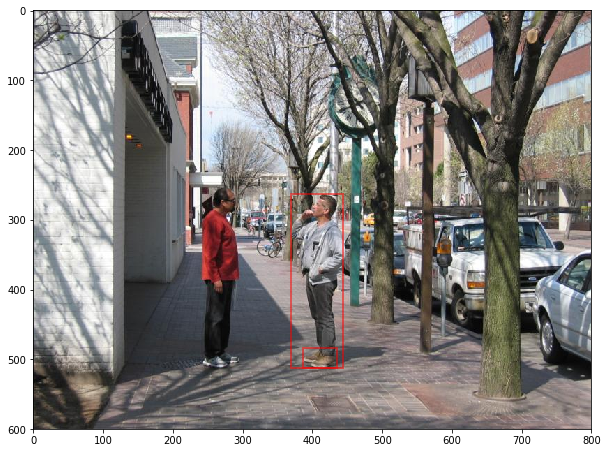

In [139]:
import cv2
import matplotlib.pyplot as plt
import pylab
from skimage import transform
# display plots in this notebook
%matplotlib inline


im = cv2.imread(img_paths[img_idx])
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
plt.figure(figsize = (10, 10))
plt.imshow(im)

# for i in range(img_idx, img_idx+base, 1):
i = 7
    
bbox = scale_sub_boxes[i]

#     cls = classes[str(sub_labels[i][0])]

plt.gca().add_patch(
    plt.Rectangle((bbox[0], bbox[1]),
                  bbox[2] - bbox[0],
                  bbox[3] - bbox[1], fill=False,
                  edgecolor='red', linewidth=2, alpha=0.5)
        )

bbox = scale_obj_boxes[i]
#     cls = classes[str(obj_labels[i][0])]
plt.gca().add_patch(
    plt.Rectangle((bbox[0], bbox[1]),
                  bbox[2] - bbox[0],
                  bbox[3] - bbox[1], fill=False,
                  edgecolor='red', linewidth=2, alpha=0.5)
        )


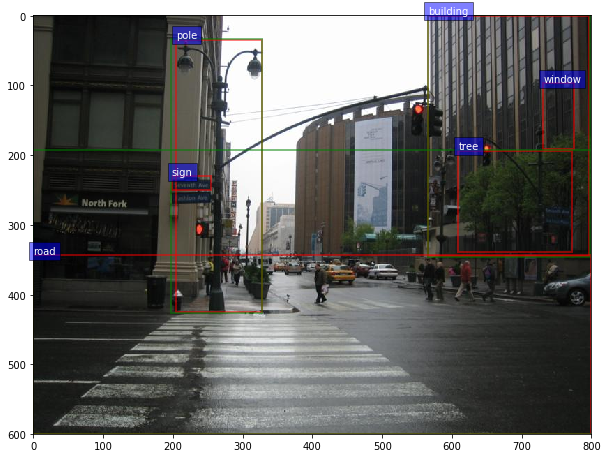

In [19]:
import cv2
import matplotlib.pyplot as plt
import pylab
from skimage import transform
# display plots in this notebook
%matplotlib inline


im = cv2.imread(img_paths[img_idx])
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
plt.figure(figsize = (10, 10))
plt.imshow(im)

for i in range(img_idx, img_idx+base, 1):
    
    bbox = scale_sub_boxes[i]
    union_bbox = scale_union_boxes[i]

    cls = classes[str(sub_labels[i][0])]

    plt.gca().add_patch(
        plt.Rectangle((bbox[0], bbox[1]),
                      bbox[2] - bbox[0],
                      bbox[3] - bbox[1], fill=False,
                      edgecolor='red', linewidth=2, alpha=0.5)
            )
    plt.gca().text(bbox[0], bbox[1] - 2,
                        '%s' % (cls),
                        bbox=dict(facecolor='blue', alpha=0.5),
                        fontsize=10, color='white')


    bbox = scale_obj_boxes[i]
    cls = classes[str(obj_labels[i][0])]
    plt.gca().add_patch(
        plt.Rectangle((bbox[0], bbox[1]),
                      bbox[2] - bbox[0],
                      bbox[3] - bbox[1], fill=False,
                      edgecolor='red', linewidth=2, alpha=0.5)
            )
    plt.gca().text(bbox[0], bbox[1] - 2,
                        '%s' % (cls),
                        bbox=dict(facecolor='blue', alpha=0.5),
                        fontsize=10, color='white')


    plt.gca().add_patch(
        plt.Rectangle((union_bbox[0]-1, union_bbox[1]-1),
                      union_bbox[2] - union_bbox[0] + 2,
                      union_bbox[3] - union_bbox[1] + 2, fill=False,
                      edgecolor='green', linewidth=2, alpha=0.5)
            )
    
    


## load VG_bbox_label_attr.pkl

In [1]:
# Load classes
import os
path = '/2t/jackyyeh/scene-graph-TF-release/data_tools/VG/jacky_object_list.txt'

data_path = '/2t/jackyyeh/bottom-up-attention/data/genome/1600-400-20' # 1600 objects, 400 attributes, 20 relations

# Load classes
classes = ['__background__']
with open(os.path.join(path)) as f:
    for object in f.readlines():
        classes.append(object.split(',')[0].lower().strip())

classes_1600 = ['__background__']
with open(os.path.join(data_path, 'objects_vocab.txt')) as f:
    for object in f.readlines():
        classes_1600.append(object.split(',')[0].lower().strip())

# Load attributes
attributes = ['__no_attribute__']
with open(os.path.join(data_path, 'attributes_vocab.txt')) as f:
    for att in f.readlines():
        attributes.append(att.split(',')[0].lower().strip())

In [2]:
import json
image_dir = '/2t/jackyyeh/dataset/VG'
image_file = '/2t/jackyyeh/im2p/data/image_ids/test_imgs_ids.json'
fns = []
with open(image_file, 'r') as f:
    imd_ids = json.load(f)

fns = [os.path.join(image_dir, '{}.jpg'.format(imd_id)) for imd_id in imd_ids]

In [4]:
import pickle
processedVG_path = '../VG_bbox_label_attr_0to50000.pkl'

with open(processedVG_path, 'r') as f:
    data = pickle.load(f)

In [5]:
sum(data['num_rois']) / float(len(data['num_rois']))

50.013560883760995

In [49]:
data.keys()

['num_rois', 'labels', 'attrs_conf', 'boxes', 'attrs', 'img_ids']

In [78]:
labels_in_jacky_classes = []
for i, c in enumerate(classes_1600):
    if c in classes:
        labels_in_jacky_classes.append(i)
print labels_in_jacky_classes

[0, 3, 14, 15, 18, 31, 34, 36, 37, 40, 41, 43, 44, 50, 51, 52, 53, 54, 56, 60, 61, 63, 65, 70, 71, 72, 73, 84, 86, 87, 91, 92, 93, 94, 97, 98, 100, 101, 107, 110, 111, 116, 118, 119, 120, 124, 126, 127, 128, 129, 132, 136, 137, 138, 139, 140, 141, 147, 156, 158, 160, 162, 163, 165, 167, 168, 171, 173, 174, 177, 178, 179, 181, 182, 183, 184, 190, 191, 192, 194, 197, 198, 201, 202, 204, 208, 210, 213, 221, 223, 224, 225, 226, 227, 232, 235, 237, 241, 243, 244, 246, 249, 252, 260, 263, 264, 267, 268, 274, 275, 277, 279, 284, 286, 288, 290, 291, 292, 293, 297, 300, 301, 304, 309, 310, 311, 315, 319, 320, 321, 327, 328, 334, 335, 336, 340, 362, 365, 367, 370, 372, 373, 374, 375, 381, 386, 392, 396, 398, 437, 439, 441, 450, 453, 454, 455, 463, 466, 467, 468, 470, 479, 482, 487, 496, 501, 504, 505, 507, 518, 527, 528, 530, 531, 539, 541, 543, 549, 557, 568, 577, 585, 589, 595, 601, 602, 604, 609, 611, 612, 624, 625, 629, 645, 650, 661, 662, 663, 664, 673, 676, 680, 683, 684, 698, 702, 716, 72

In [108]:
classes_282 = classes
classes_1600to282 = {}
for i, c in enumerate(classes_1600):
    if c in classes_282:
        classes_1600to282[i] = classes_282.index(c)
print classes_1600to282

{0: 0, 3: 72, 716: 139, 518: 217, 14: 158, 15: 102, 528: 9, 18: 90, 531: 142, 1228: 163, 1028: 160, 539: 174, 541: 263, 31: 116, 34: 71, 36: 199, 37: 13, 40: 156, 41: 103, 43: 128, 44: 233, 557: 123, 1070: 25, 50: 235, 51: 34, 52: 119, 53: 26, 54: 210, 1289: 12, 56: 152, 60: 141, 61: 228, 735: 38, 63: 247, 65: 177, 70: 159, 71: 122, 72: 77, 73: 237, 1100: 276, 589: 46, 595: 207, 84: 62, 86: 107, 87: 3, 601: 83, 602: 203, 91: 242, 92: 165, 93: 29, 94: 129, 702: 30, 97: 175, 98: 267, 611: 127, 100: 108, 101: 274, 107: 249, 530: 146, 110: 204, 111: 2, 624: 243, 625: 153, 787: 55, 116: 266, 629: 125, 118: 52, 119: 130, 120: 99, 124: 193, 874: 10, 126: 270, 127: 161, 128: 32, 129: 184, 1154: 101, 132: 216, 645: 49, 136: 282, 137: 239, 138: 95, 139: 155, 140: 246, 141: 273, 1409: 35, 147: 92, 661: 176, 662: 31, 663: 227, 664: 5, 156: 167, 158: 234, 160: 209, 673: 33, 162: 211, 163: 124, 676: 265, 165: 22, 585: 133, 167: 89, 168: 137, 171: 80, 684: 23, 173: 53, 174: 196, 1165: 229, 177: 63, 1

In [60]:
idxs = []
for img_id in fns:
    img_id = int(img_id.split('/')[-1].strip('.jpg'))
    idxs.append(data['img_ids'].index(img_id))

In [72]:
labels = np.array(data['labels'])[idxs]
boxes = np.array(data['boxes'])[idxs]
attrs = np.array(data['attrs'])[idxs]
attrs_conf = np.array(data['attrs_conf'])[idxs]
num_rois = np.array(data['num_rois'])[idxs]

In [83]:
len(idxs)

2489

In [110]:
obj_pairs = []
for i in range(len(idxs)):
    
    keep_box = [box_idx for box_idx, label in enumerate(labels[i]) if label in labels_in_jacky_classes]
    
    i_label = labels[i][keep_box]
    i_box = boxes[i][keep_box]
    i_num_roi = len(keep_box)
    
    # n * (n-1) pairs
    sub_boxes_i = np.zeros(( i_num_roi*(i_num_roi-1), 4))
    obj_boxes_i = np.zeros(( i_num_roi*(i_num_roi-1), 4))
    sub_labels_i = np.zeros(( i_num_roi*(i_num_roi-1), ))
    obj_labels_i = np.zeros(( i_num_roi*(i_num_roi-1), ))

    
    print i_label
    print [classes_1600to282[label] for label in i_label]
    
    for j in range(i_num_roi):
        other_idxs = range(i_num_roi)
        other_idxs.remove(j)
        
#         print i_num_roi
#         print i_label[other_idxs]
#         print i_obj_pairs[j*(i_num_roi-1):(j+1)*(i_num_roi-1), 1].shape
#         print i_label[other_idxs].shape
#         raw_input()
        
        obj_labels_i[j*(i_num_roi-1):(j+1)*(i_num_roi-1)] = np.array([classes_1600to282[label] for label in i_label[other_idxs]])
    
        sub_labels_i[j*(i_num_roi-1):(j+1)*(i_num_roi-1)] = classes_1600to282[ i_label[j] ]
#         obj_labels_i[j*(i_num_roi-1):(j+1)*(i_num_roi-1)] = classes_1600to282[ i_label[other_idxs] ]
        sub_boxes_i[j*(i_num_roi-1):(j+1)*(i_num_roi-1), :] = i_box[j]
        obj_boxes_i[j*(i_num_roi-1):(j+1)*(i_num_roi-1), :] = i_box[other_idxs]
    
#     obj_pairs.append( i_obj_pairs )
    
    print sub_labels_i
    print obj_labels_i
    raw_input()
    
#     print keep_box
#     print box
#     print attr
#     print attr_conf
#     print i_num_roi
#     raw_input()
    

[ 72 274 274 274 467 191 504 191 504]
[77, 178, 178, 178, 172, 171, 91, 171, 91]
[ 77.  77.  77.  77.  77.  77.  77.  77. 178. 178. 178. 178. 178. 178.
 178. 178. 178. 178. 178. 178. 178. 178. 178. 178. 178. 178. 178. 178.
 178. 178. 178. 178. 172. 172. 172. 172. 172. 172. 172. 172. 171. 171.
 171. 171. 171. 171. 171. 171.  91.  91.  91.  91.  91.  91.  91.  91.
 171. 171. 171. 171. 171. 171. 171. 171.  91.  91.  91.  91.  91.  91.
  91.  91.]
[178. 178. 178. 172. 171.  91. 171.  91.  77. 178. 178. 172. 171.  91.
 171.  91.  77. 178. 178. 172. 171.  91. 171.  91.  77. 178. 178. 172.
 171.  91. 171.  91.  77. 178. 178. 178. 171.  91. 171.  91.  77. 178.
 178. 178. 172.  91. 171.  91.  77. 178. 178. 178. 172. 171. 171.  91.
  77. 178. 178. 178. 172. 171.  91.  91.  77. 178. 178. 178. 172. 171.
  91. 171.]


KeyboardInterrupt: 